## Постановка задачи

Продуктовые магазины, работающие по принципу «пришёл, купил, ушёл», всегда находятся в сложном положении, когда дело касается закупок и прогнозирования продаж. Если спрогнозировать немного больше, чем нужно, то у бакалейщиков останутся излишки скоропортящихся товаров. Если спрогнозировать немного меньше, чем нужно, то популярные товары быстро раскупят, а деньги останутся на столе, а покупатели будут недовольны.

Проблема становится более сложной по мере того, как розничные продавцы открывают новые магазины с уникальными потребностями, новыми продуктами, постоянно меняющимися сезонными вкусами и непредсказуемым маркетингом. Corporación Favorita, крупная эквадорская сеть продуктовых магазинов, знает об этом не понаслышке. У них сотни супермаркетов, в которых на полках представлено более 200 000 различных продуктов.

Corporación Favorita предложила сообществу Kaggle создать модель, которая будет более точно прогнозировать продажи продукции. В настоящее время они полагаются на субъективные методы прогнозирования, подкреплённые очень небольшим количеством данных, и практически не используют автоматизацию для выполнения планов. Они с нетерпением ждут возможности увидеть, как машинное обучение может помочь им лучше удовлетворять потребности клиентов, предлагая нужное количество нужных товаров в нужное время.



**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать количество нужных товаров.

**Техническая задача для нас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик будет предсказывать числовой признак. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания целевой переменной для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.

Для базового знакомства с данными и признаками нужно почитать readme.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# DATA MANIPULATION
import numpy as np # linear algebra
import random as rd # generating random numbers
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime # manipulating date formats
from operator import add # elementwise addition

# VIZUALIZATION
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import folium # plotting data on interactive maps
import squarify
%matplotlib inline
import missingno as msno
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
color = sns.color_palette()

# UNSUPERVISED LEARNING
from sklearn.cluster import AgglomerativeClustering as AggClust # Hierarchical Clustering
from scipy.cluster.hierarchy import ward,dendrogram # Hierarchical Clustering + Dendograms

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic





выгружаем данные

In [2]:
items = pd.read_csv("data/items.csv")
holiday_events = pd.read_csv("data/holidays_events.csv", parse_dates=['date'])
stores = pd.read_csv("data/stores.csv")
oil = pd.read_csv("data/oil.csv", parse_dates=['date'])
transactions = pd.read_csv("data/transactions.csv", parse_dates=['date'])
# the full training data's output: "125,497,040 rows | 6 columns"
#Therefore I will only load approx 5% of the data just to get a rough idea of what is in store for us.
train = pd.read_csv("data/train.csv", nrows=6000000  , parse_dates=['date'])
train_large = pd.read_csv('data/train.csv', skiprows = 115000000, names = train.columns, parse_dates = ['date'])


In [3]:
train_large.date.min()

Timestamp('2017-05-08 00:00:00')

In [4]:
train.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 274.7 MB


In [6]:
train.isnull().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    6000000
dtype: int64

в обучающем наборе пропуски есть только в onpromotion, как и было указано в предисловии

In [7]:
print("Nulls in Oil columns: {0} => {1}".format(oil.columns.values,oil.isnull().any().values))
print("="*70)
print("Nulls in holiday_events columns: {0} => {1}".format(holiday_events.columns.values,holiday_events.isnull().any().values))
print("="*70)
print("Nulls in stores columns: {0} => {1}".format(stores.columns.values,stores.isnull().any().values))
print("="*70)
print("Nulls in transactions columns: {0} => {1}".format(transactions.columns.values,transactions.isnull().any().values))


Nulls in Oil columns: ['date' 'dcoilwtico'] => [False  True]
Nulls in holiday_events columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] => [False False False False False False]
Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]
Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]


Единственные отсутствующие данные содержатся в файле данных о нефти, который содержит историческую дневную цену на нефть

# Oil Data

In [8]:
oil.head(3)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


In [9]:
trace = go.Scatter(
    name='Oil prices',
    x=oil['date'],
    y=oil['dcoilwtico'].dropna(),
    mode='lines',
    line=dict(color='rgb(20, 15, 200, 0.8)'),
    #fillcolor='rgba(68, 68, 68, 0.3)',
    fillcolor='rgba(0, 0, 216, 0.3)',
    fill='tonexty' )

data = [trace]

layout = go.Layout(
    yaxis=dict(title='Daily Oil price'),
    title='Daily oil prices from Jan 2013 till July 2017',
    showlegend = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pandas-time-series-error-bars')


Из графика видно, что мы имеем несколько периодов цен на нефть. С 2013 по 2014 цены на нефть держатся высоко и стабильно. С 2014 по 2016 было резкое падение, после чего цена снова нашла устойчивое положение. Эти данные в целом совпадают с открытой информацией из интернета. 

Для нас конечно лучше рассматривать те периоды, когда цены на нефть стабильны. Потому что ее цена сильно влияет абсолютно на все в Эквадоре, если по простому. А моменты резких скачков скорее запутают модели или приведут к их не нужному усложнению. 

Но посмотрим, что у нас получится.

# Stores Data

In [10]:
stores.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


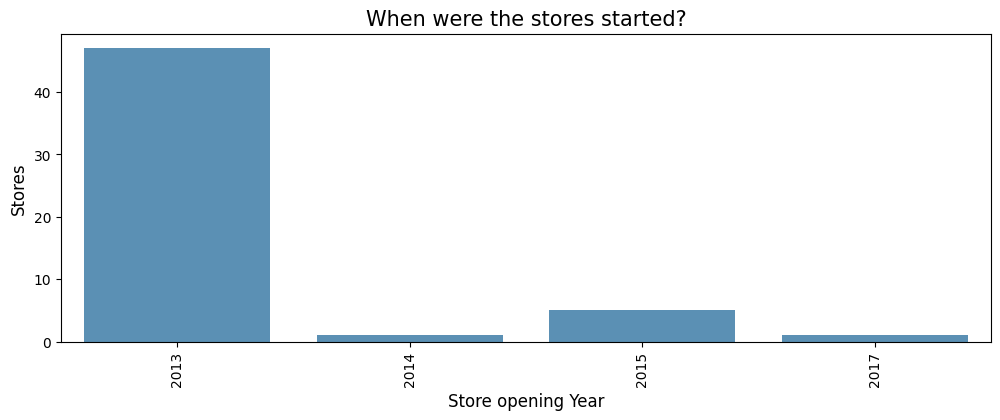

In [11]:
temp=transactions.groupby(['store_nbr']).agg({'date':[np.min,np.max]}).reset_index()
temp['store_age']=temp['date']['max']-temp['date']['min']
temp['open_year']=temp['date']['min'].dt.year
data=temp['open_year'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=data.index,y=data.values, alpha=0.8, color=color[0])
plt.ylabel('Stores', fontsize=12)
plt.xlabel('Store opening Year', fontsize=12)
plt.title('When were the stores started?', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()


В 2015 году было открыто 5 магазинов, а в 2014 и 2017 годах - по 1 магазину. Основное количество магазинов было открыто в 2013 году еще до кризиса и видимо уже тогда сеть расширилась до максимума.

In [12]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


Посмотрим, как расположенны магазины по штатам и городам.

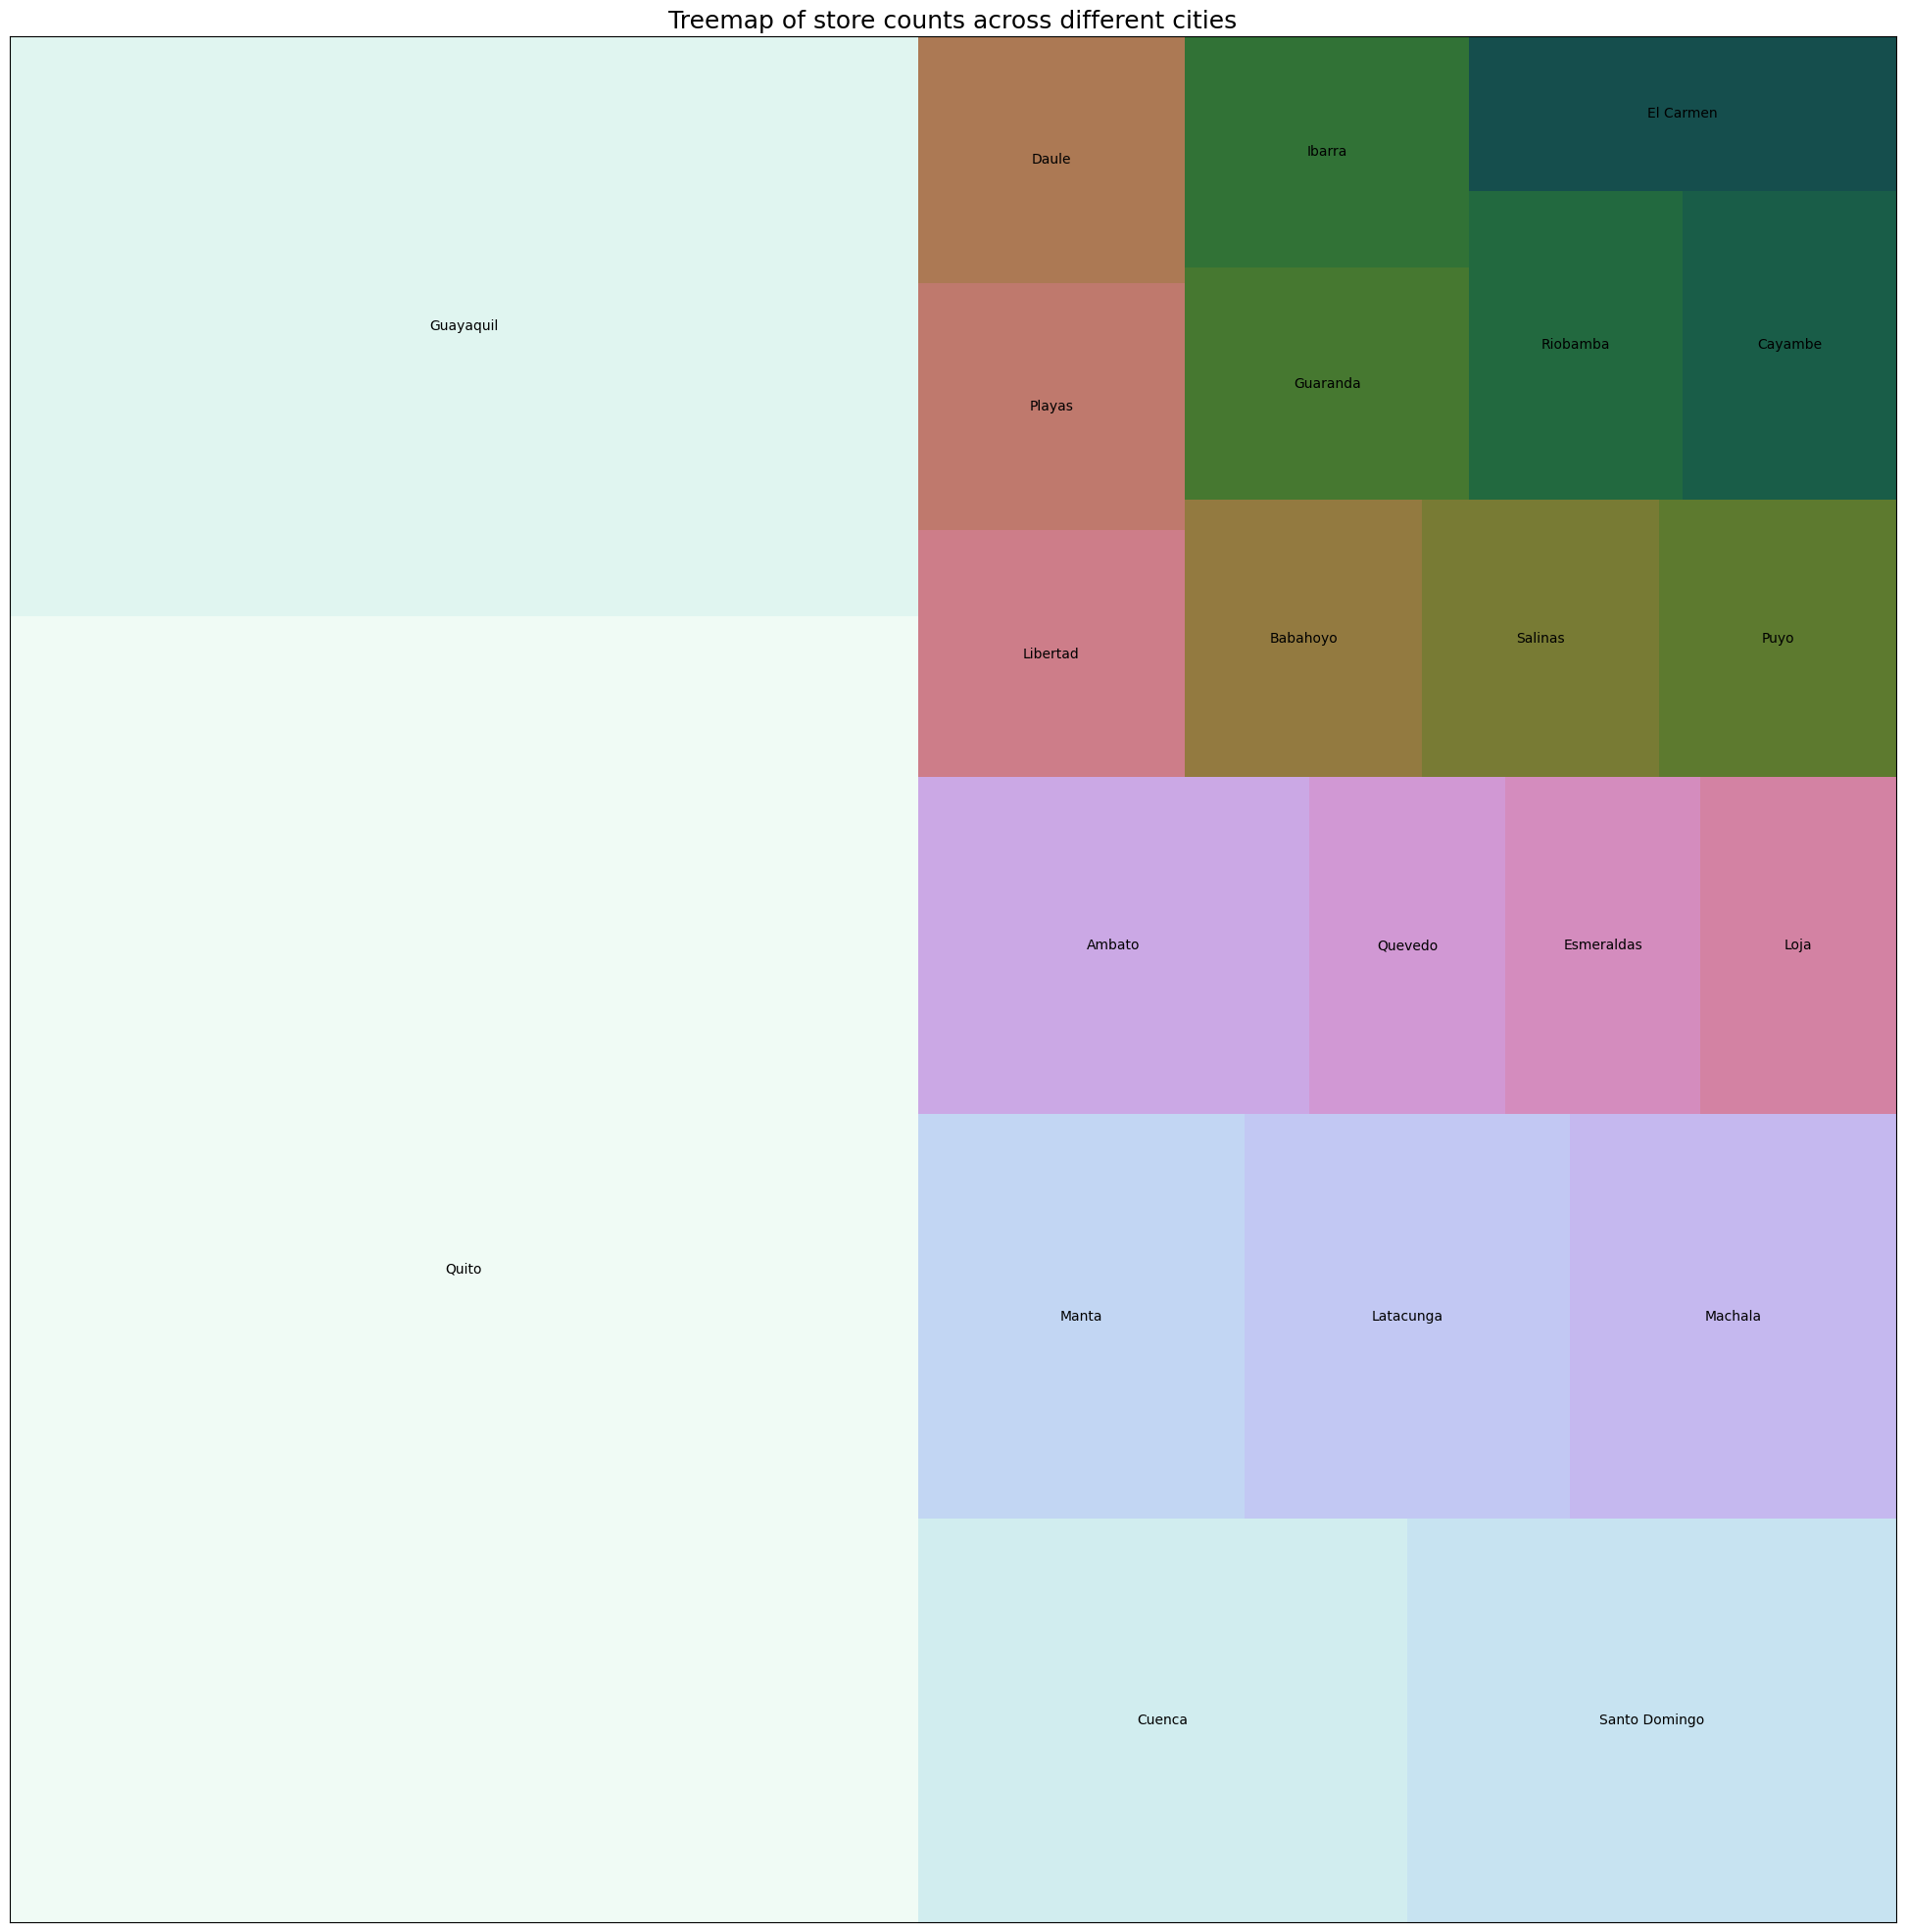

In [13]:
fig = plt.figure(figsize=(25, 21))
marrimeko=stores.city.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=marrimeko.values,label=marrimeko.index,
            color=sns.color_palette('cubehelix_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different cities", fontsize=18)
plt.show();


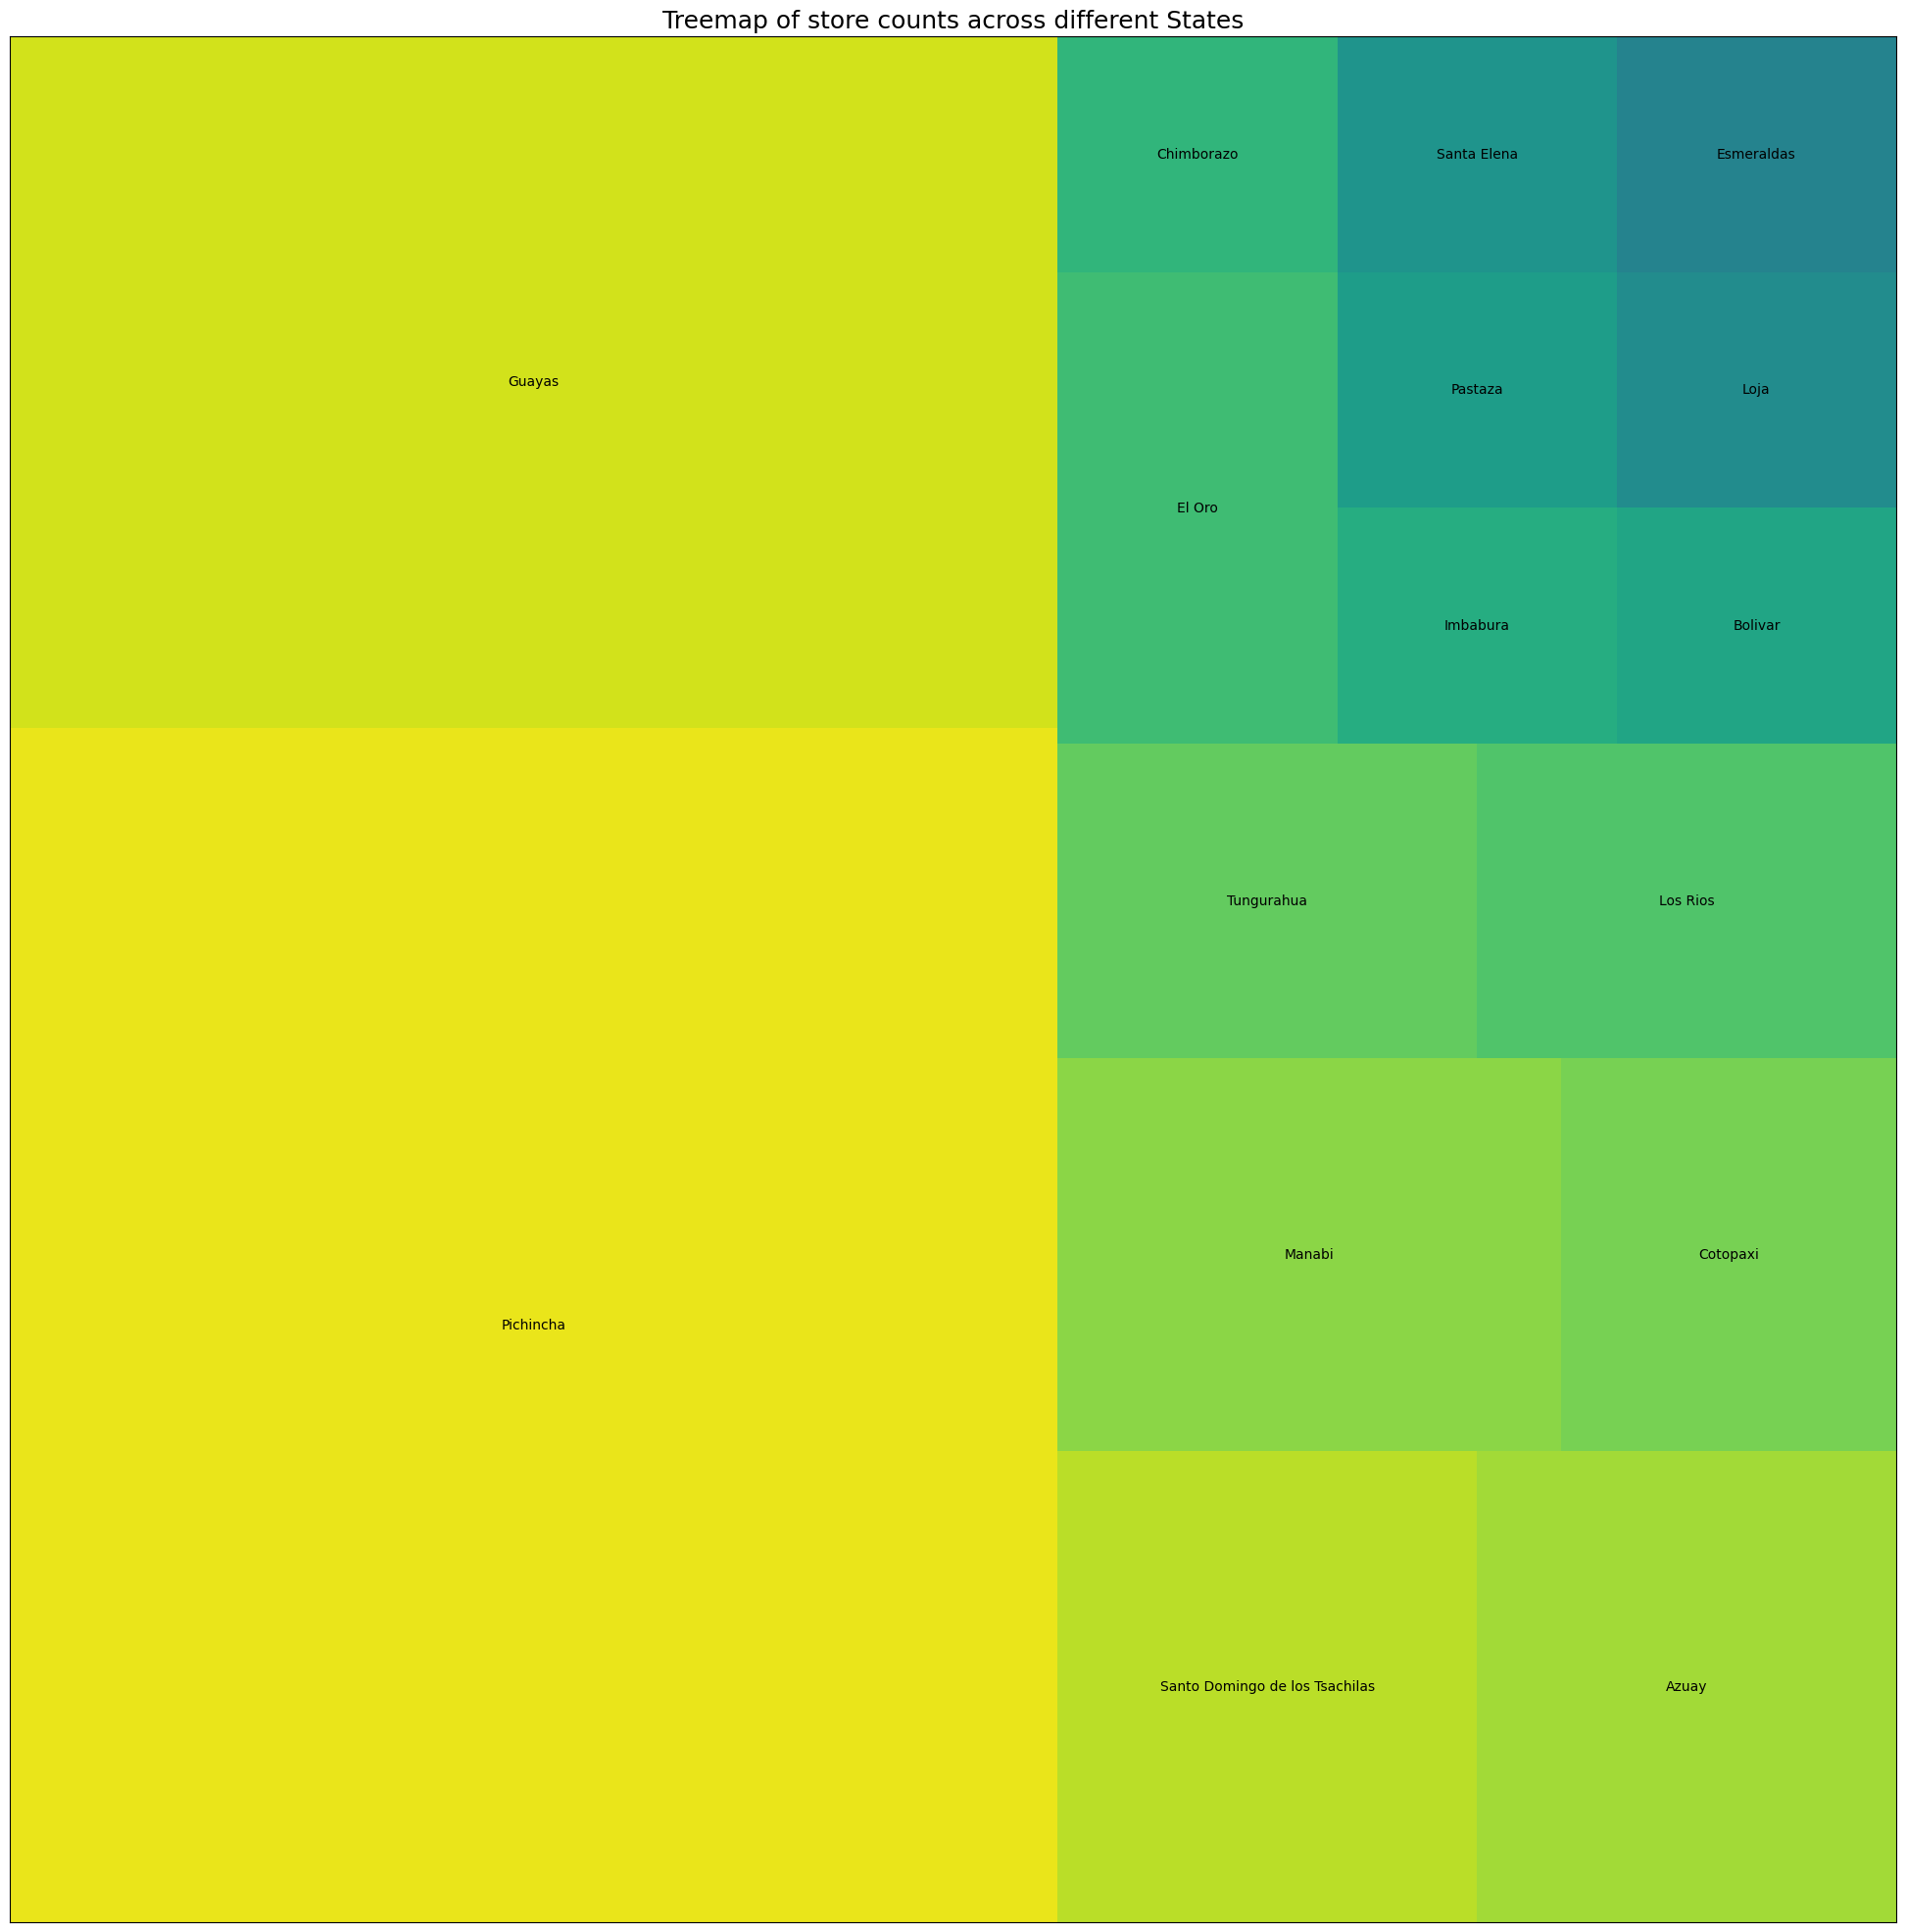

In [14]:
fig = plt.figure(figsize=(25, 21))
marrimeko=stores.state.value_counts().to_frame()
ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(sizes=marrimeko.values,label=marrimeko.index,
            color=sns.color_palette('viridis_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig=plt.gcf()
fig.set_size_inches(40,25)
plt.title("Treemap of store counts across different States", fontsize=18)
plt.show()


In [15]:
stores.state.unique()


array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

Номера наших магазинов теперь будут расположены по соответствующим кластерам магазинов, что позволит нам увидеть, есть ли какие-либо очевидные тенденции или связи в данных. Для этого я буду использовать операторы groupby и pivot, чтобы сгруппировать наш фрейм данных stores на основе значений "store nbr" и "cluster". 

In [16]:
stores.store_nbr.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

Text(0.5, 1.0, 'Store numbers and the clusters they are assigned to')

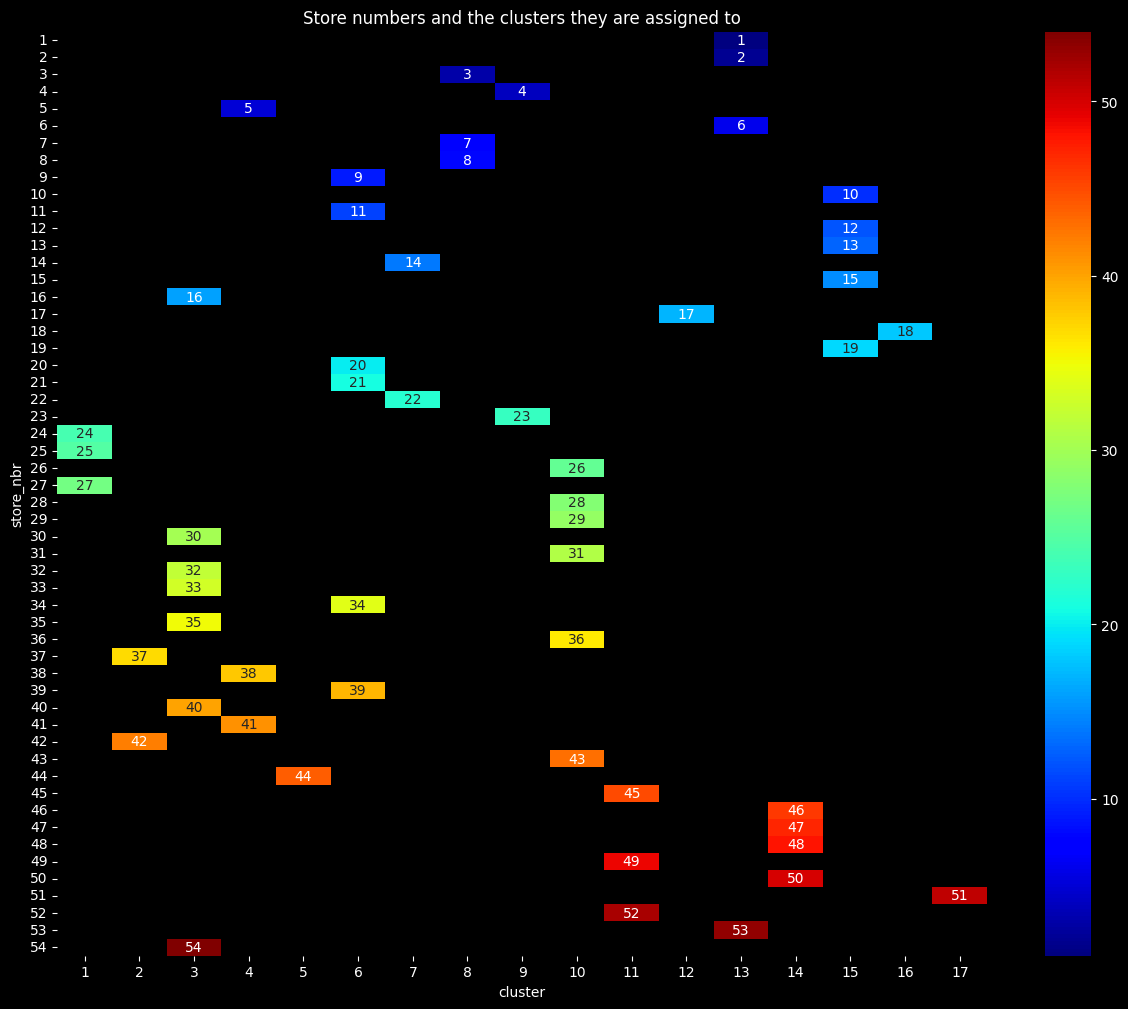

In [17]:
# Finally plot the seaborn heatmap
plt.style.use('dark_background')
plt.figure(figsize=(15,12))
store_pivot = stores.dropna().pivot(index="store_nbr",columns="cluster", values="store_nbr")
ax = sns.heatmap(store_pivot, cmap='jet', annot=True, linewidths=0, linecolor='white')
plt.title('Store numbers and the clusters they are assigned to')


Визуализируя соседние номера магазинов на основе кластеризации, мы можем выявить определенные закономерности. Например, кластеры 3, 6, 10 и 15 являются наиболее распространенными кластерами магазинов, основанными на том факте, что им приписано больше store_nbr, чем остальным, в то время как на другом конце спектра у нас есть кластеры 5 и 17, которые связаны только с магазинами 44 и 51 соответственно

Мы можем посмотреть на распределение кластеров в зависимости от типа магазина, чтобы увидеть, можем ли мы выявить какую-либо очевидную взаимосвязь

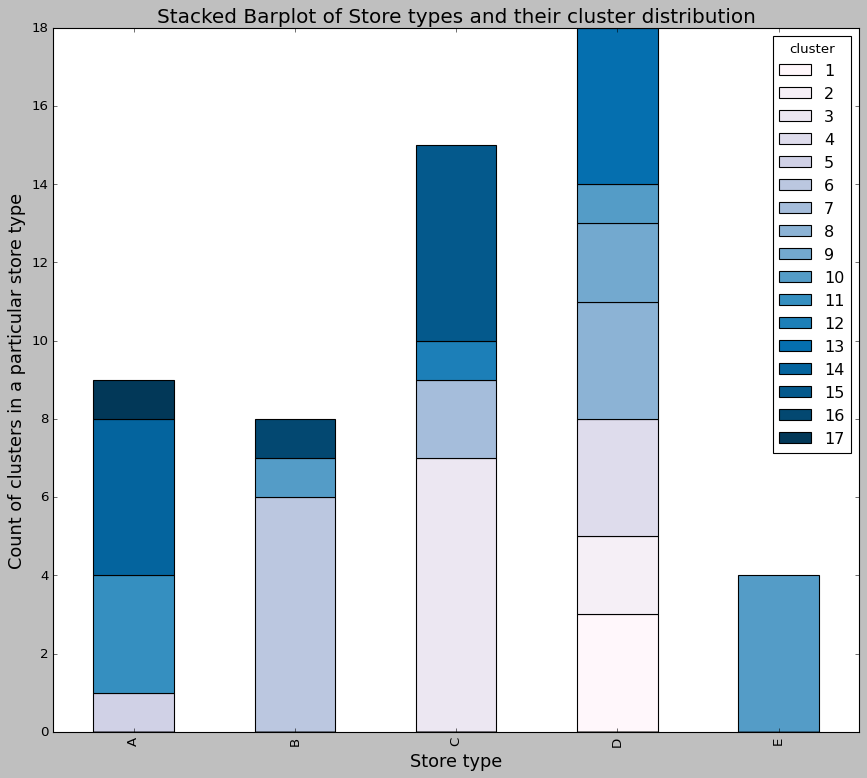

In [18]:
plt.style.use('classic')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()


C и D самые распространенные типы магазинов.

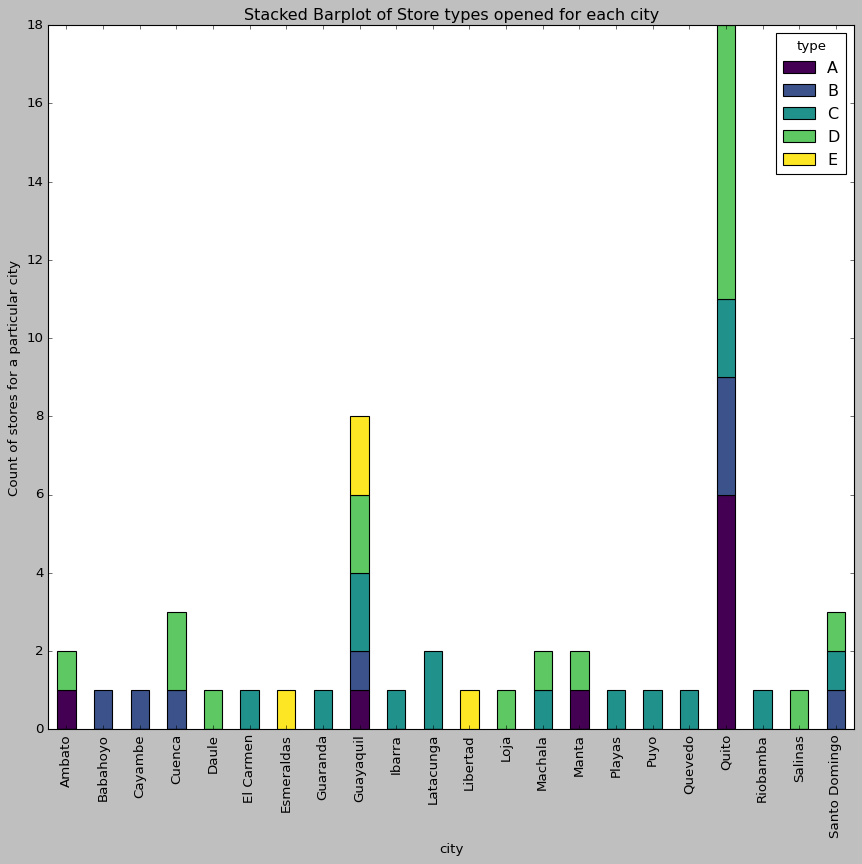

In [19]:
plt.style.use('classic')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()


Гуаякиль и Кито - два города, которые выделяются с точки зрения ассортимента доступных видов розничной торговли. Это неудивительно, учитывая, что Кито - столица Эквадора, а Гуаякиль - крупнейший и густонаселенный мегаполис страны. В результате можно было бы ожидать, что Corporacion Favorita будет ориентирована на эти крупные города с самыми разнообразными типами магазинов, о чем свидетельствует самое высокое количество nbr магазинов, приходящихся на эти два города.

# Holiday Events Data

In [20]:
holiday_events.head(3)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


In [21]:
holiday_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [22]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


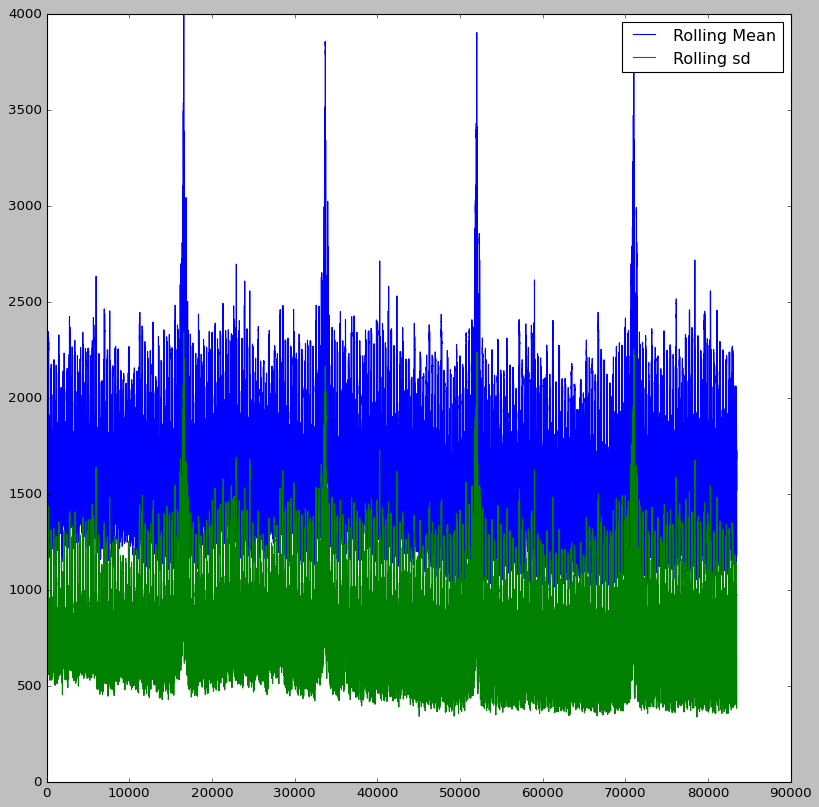

In [23]:
#does the transactions peak at holiday events?
plt.figure(figsize=(12,12))
plt.plot(transactions.transactions.rolling(window=30,center=False).mean(),label='Rolling Mean');
plt.plot(transactions.transactions.rolling(window=30,center=False).std(),label='Rolling sd');
plt.legend();


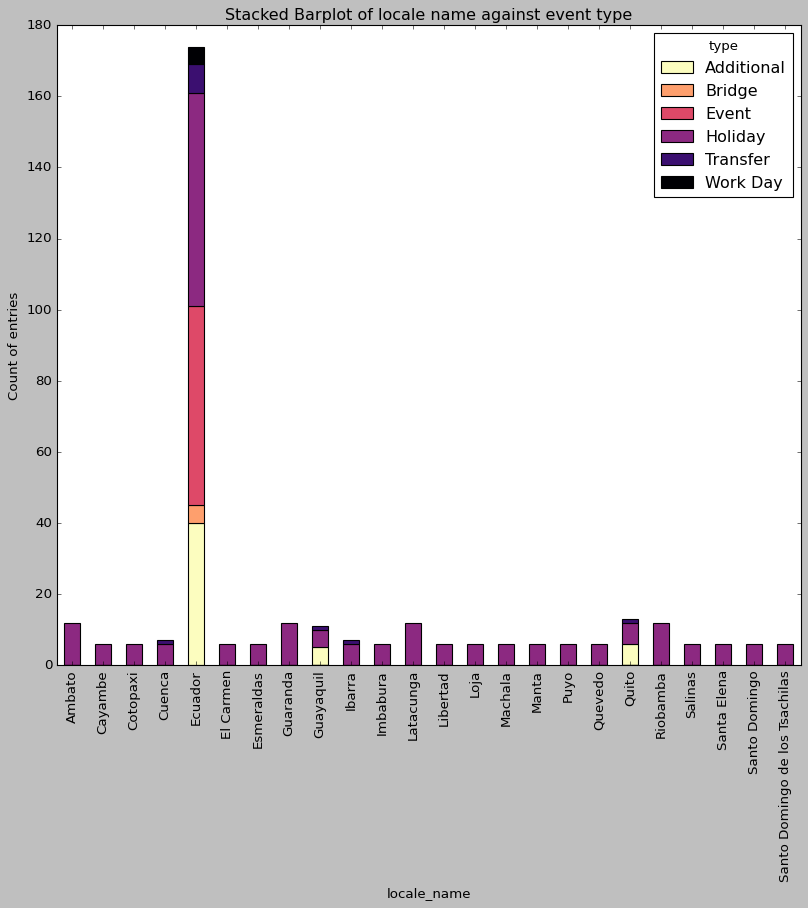

In [24]:
plt.style.use('classic')
holiday_local_type = holiday_events.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()


# Transactions data

In [25]:
transactions.head(3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


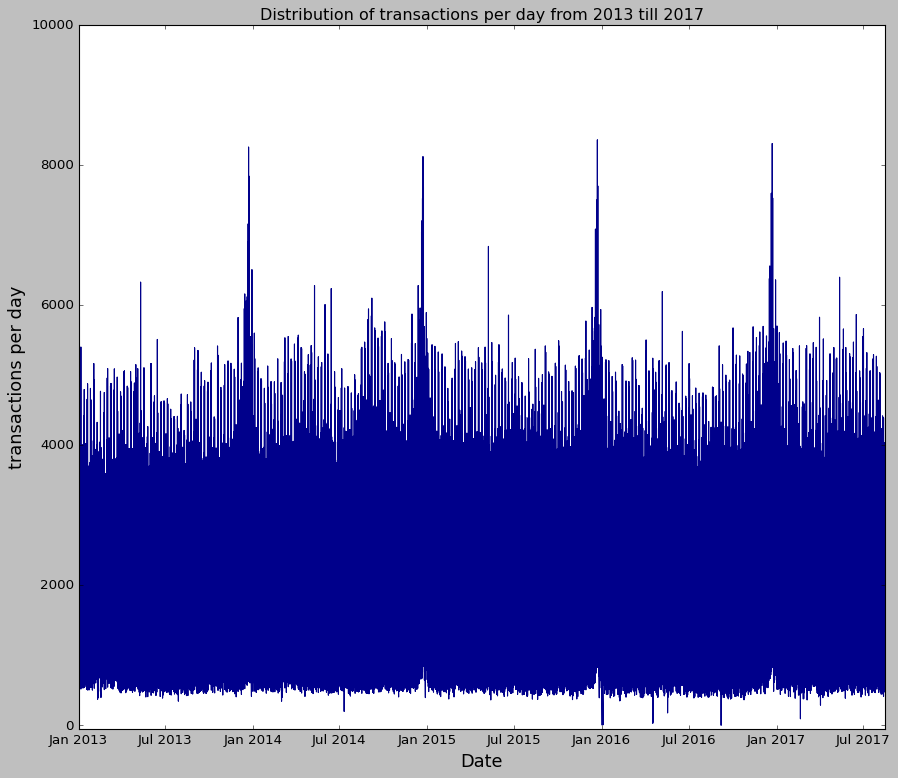

In [26]:
plt.style.use('classic')
plt.figure(figsize=(13,11))
plt.plot(transactions.date.values, transactions.transactions.values, color='darkblue')
plt.ylim(-50, 10000)
plt.title("Distribution of transactions per day from 2013 till 2017")
plt.ylabel('transactions per day', fontsize= 16)
plt.xlabel('Date', fontsize= 16)
plt.show()


Наибольший ежегодный периодический всплеск транзакций, по-видимому, приходится на конец года, в декабре. Возможно, это связано с какой-то рождественской распродажей / скидкой, которую Corporacion Favorita проводит каждый декабрь.

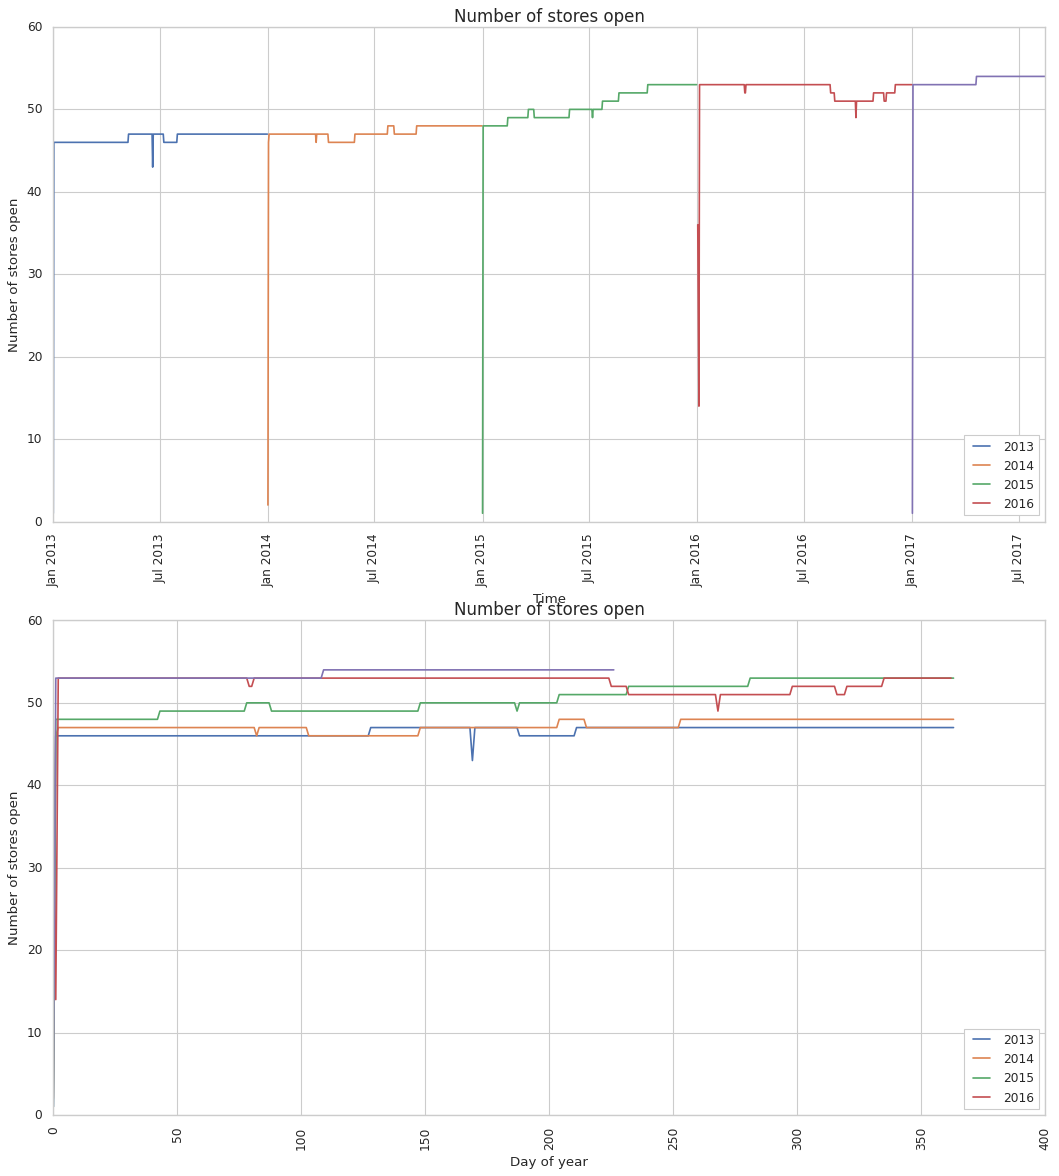

In [27]:
#transactions
# month over month sales
transactions['date']=pd.to_datetime(transactions['date'])
temp=transactions.groupby(['date']).aggregate({'store_nbr':'count','transactions':np.sum})
temp=temp.reset_index()
temp_2013=temp[temp['date'].dt.year==2013].reset_index(drop=True)
temp_2014=temp[temp['date'].dt.year==2014].reset_index(drop=True)
temp_2015=temp[temp['date'].dt.year==2015].reset_index(drop=True)
temp_2016=temp[temp['date'].dt.year==2016].reset_index(drop=True)
temp_2017=temp[temp['date'].dt.year==2017].reset_index(drop=True)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(16,17))
plt.subplot(211)
plt.plot(temp_2013['date'],temp_2013.iloc[:,1],label="2013")
plt.plot(temp_2014['date'],temp_2014.iloc[:,1],label="2014")
plt.plot(temp_2015['date'],temp_2015.iloc[:,1],label="2015")
plt.plot(temp_2016['date'],temp_2016.iloc[:,1],label="2016")
plt.plot(temp_2017['date'],temp_2017.iloc[:,1],label="2017")
plt.ylabel('Number of stores open', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('Number of stores open', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(['2013', '2014', '2015', '2016'], loc='lower right')

plt.subplot(212)
plt.plot(temp_2013.index,temp_2013.iloc[:,1],label="2013")
plt.plot(temp_2014.index,temp_2014.iloc[:,1],label="2014")
plt.plot(temp_2015.index,temp_2015.iloc[:,1],label="2015")
plt.plot(temp_2016.index,temp_2016.iloc[:,1],label="2016")
plt.plot(temp_2017.index,temp_2017.iloc[:,1],label="2017")


plt.ylabel('Number of stores open', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
plt.title('Number of stores open', fontsize=15)
plt.xticks(rotation='vertical')
plt.legend(['2013', '2014', '2015', '2016'], loc='lower right')
plt.show()

Кажется, есть определенные местные праздники, когда некоторые магазины закрыты. Но нет постоянной схемы праздников, когда магазины закрыты

# Store #47

Сеть основана в Кито в 1952 году (мы знали об этом из Википедии), поэтому давайте выберем магазин в Кито в качестве отправной точки, поскольку бренд там хорошо зарекомендовал себя. Давайте выберем # 47 и построим график соответствующих временных рядов транзакций. При наличии хорошо зарекомендовавшего себя магазина мы можем предсказать, что временные ряды будут практически неизменными. Также ожидается высокая сезонность, поскольку люди потребляют больше в праздничные периоды.
* ссылка https://es.wikipedia.org/wiki/Corporación_Favorita

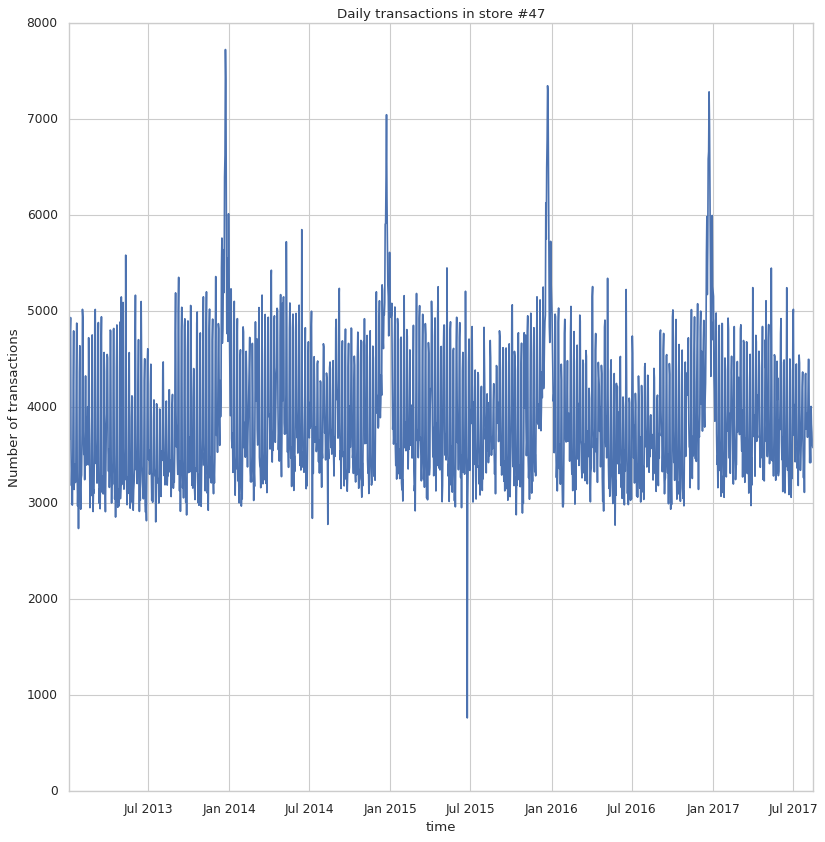

In [28]:
ts=transactions.loc[transactions['store_nbr']==47,['date','transactions']].set_index('date')
ts=ts.transactions.astype('float')
plt.figure(figsize=(12,12))
plt.title('Daily transactions in store #47')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts);


Предыдущий график транзакций стал несколько понятней.

# Items data

In [29]:
items.head()


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [30]:
items.perishable.value_counts()

perishable
0    3114
1     986
Name: count, dtype: int64

In [31]:
x, y = (list(x) for x in zip(*sorted(zip(items.family.value_counts().index, 
                                        items.family.value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    y=items.family.value_counts().values,
    x=items.family.value_counts().index,
    marker=dict(
        color=items.family.value_counts().values,
        colorscale = 'Portland',
        reversescale = False
    ),
    orientation='v',
)

layout = dict(
    title='Counts of items per family category',
    width = 800, height = 800,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


Как мы можем видеть из графика, тремя лучшими семейными категориями являются категории БАКАЛЕИ I, НАПИТКОВ и УБОРКИ

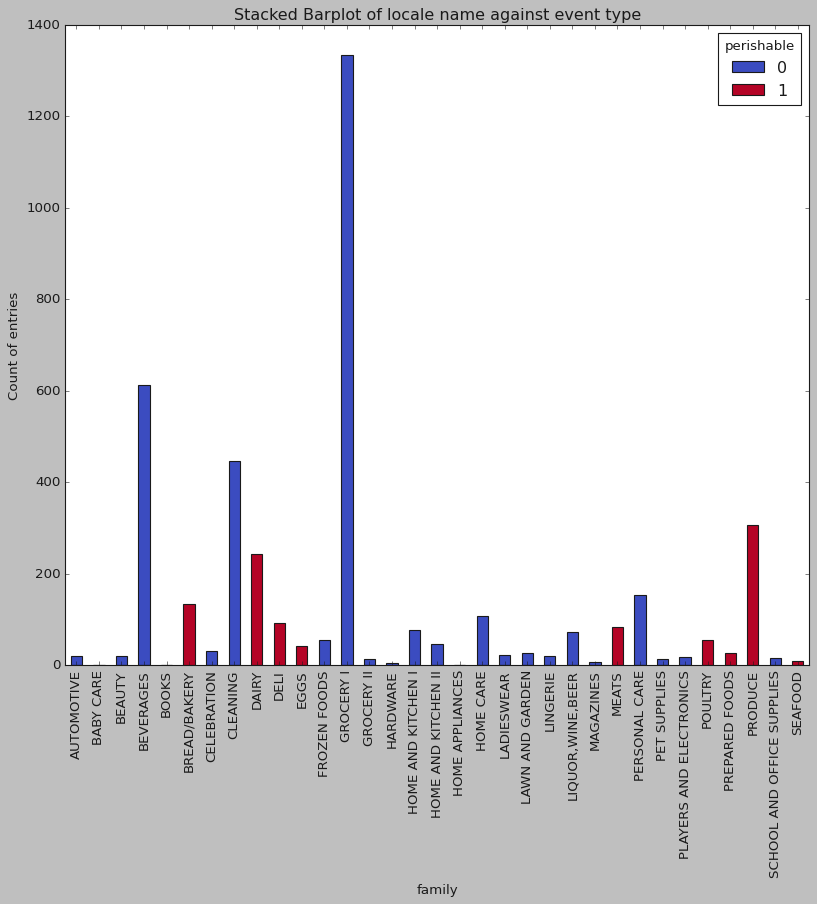

In [32]:
plt.style.use('classic')
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar',stacked=True, colormap= 'coolwarm', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()


Чего то прям нового не узнали, но стало понятно, что относится к скоропортящемуся. а что нет.

In [33]:
train = pd.read_csv("data/train.csv"  , parse_dates=['date'])


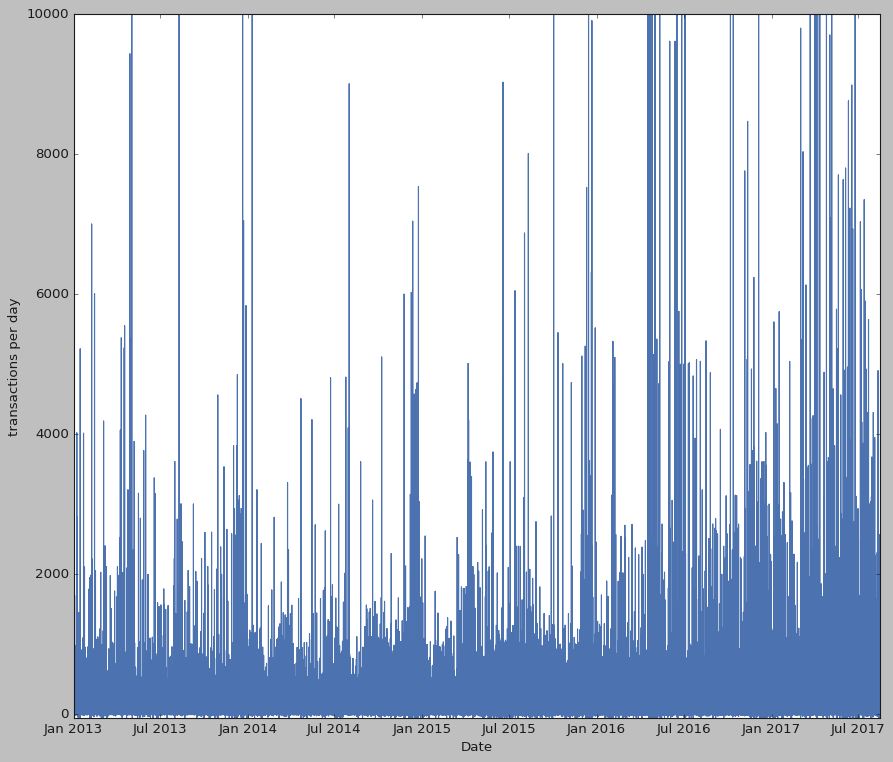

In [34]:
plt.style.use('classic')
plt.figure(figsize=(13,11))
plt.plot(train.date.values, train.unit_sales)
plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()


По всей видимости вспески примерно в одно время происходили из-за праздников или скидок.

Распределение магазинов. Эти данные уже были получены ранее, но соберем их вместе более компактно.

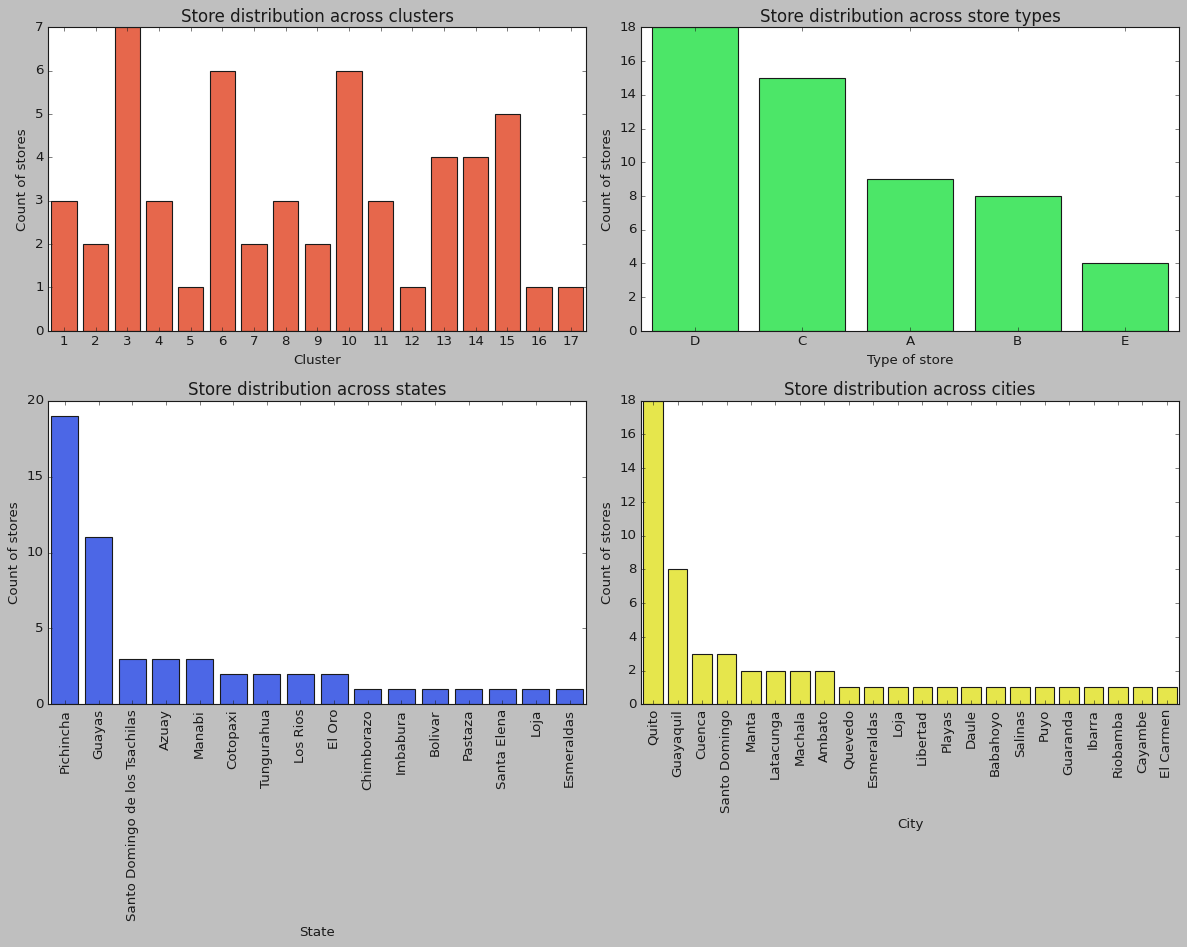

In [35]:
# Пример массива цветов
color = ['#FF5733', '#33FF57', '#3357FF', '#FFFF33', '#FF33FF', '#33FFFF']

plt.figure(figsize=(15, 12))

# Plot 1: Store distribution across clusters
plt.subplot(221)
temp = stores['cluster'].value_counts()
sns.barplot(x=temp.index, y=temp.values, color=color[0])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.title('Store distribution across clusters', fontsize=15)

# Plot 2: Store distribution across types
plt.subplot(222)
temp = stores['type'].value_counts()
sns.barplot(x=temp.index, y=temp.values, color=color[1])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('Type of store', fontsize=12)
plt.title('Store distribution across store types', fontsize=15)

# Plot 3: Store distribution across states
plt.subplot(223)
temp = stores['state'].value_counts()
sns.barplot(x=temp.index, y=temp.values, color=color[2])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('State', fontsize=12)
plt.title('Store distribution across states', fontsize=15)
plt.xticks(rotation='vertical')

# Plot 4: Store distribution across cities
plt.subplot(224)
temp = stores['city'].value_counts()
sns.barplot(x=temp.index, y=temp.values, color=color[3])
plt.ylabel('Count of stores', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.title('Store distribution across cities', fontsize=15)
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()


И снова вернемся к 47 магазину. Посмотрим на него внимательнее и попробуем извлечь какие-то более менее стабильные данные. Данные результаты могут быть не очень корректными к данным в целом, но тем не менее. 

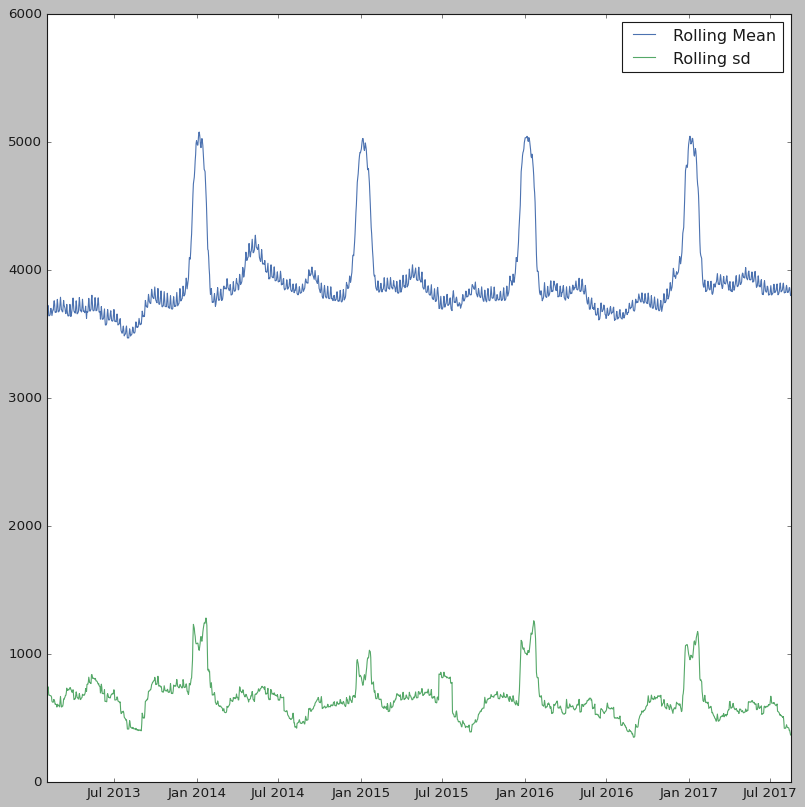

In [36]:
ts=transactions.loc[transactions['store_nbr']==47,['date','transactions']].set_index('date')
ts=ts.transactions.astype('float')

plt.figure(figsize=(12,12))
plt.plot(ts.rolling(window=30,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=30,center=False).std(),label='Rolling sd');
plt.legend();


Вот, замечаем сезонность. Из предыдущих графиков это было не очень понятно, но ожидаемо. Ведь мы рассматриваем торговую сеть в теплой стране, будет не удивительно, если сезонность окажется как-то связанна с 7 дневным циклом. Но это лишь предположение.

Также можно заметить, что всплески происходят к Рождевству, в остальное время все достаточно стабильно, хотя те или иные отступления связанны скорее всего с событиями в стране.

In [37]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                -7.069388e+00
p-value                        4.982766e-10
#Lags Used                     2.200000e+01
Number of Observations Used    1.654000e+03
Critical Value (1%)           -3.434310e+00
Critical Value (5%)           -2.863289e+00
Critical Value (10%)          -2.567701e+00
dtype: float64


Тест Дики-Фуллера подтверждает нулевую гипотезу о том, что временной ряд не является стационарным. Но значение p-value очень маленькое (меньше 0.05), что позволяет отвергнуть нулевую гипотезу. Это говорит о том, что временной ряд все таки стационарен.



Давайте начнем с использования модели ARIMA для этого временного ряда и посмотрим, насколько мы успешны. ARIMA расшифровывается, как авторегрессионная интегрированная скользящая средняя.

Модель ARIMA имеет три параметра, соответствующие компонентам AR, I и MA.:

* Количество членов авторегрессии (AR) (p): члены AR - это просто лаги зависимой переменной.
* Количество различий (d): это количество несезонных различий.
* Количество членов скользящей средней (MA) (q): члены MA представляют собой запаздывающие ошибки прогноза в уравнении прогнозирования.

Мы установим d равным 0. Давайте начнем с проверки автокорреляции нашего временного ряда, чтобы лучше понять его и оценить, какими должны быть параметры нашей модели.

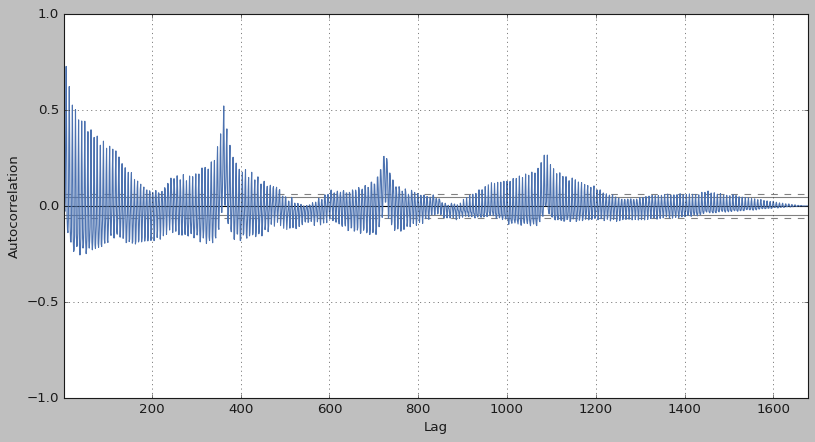

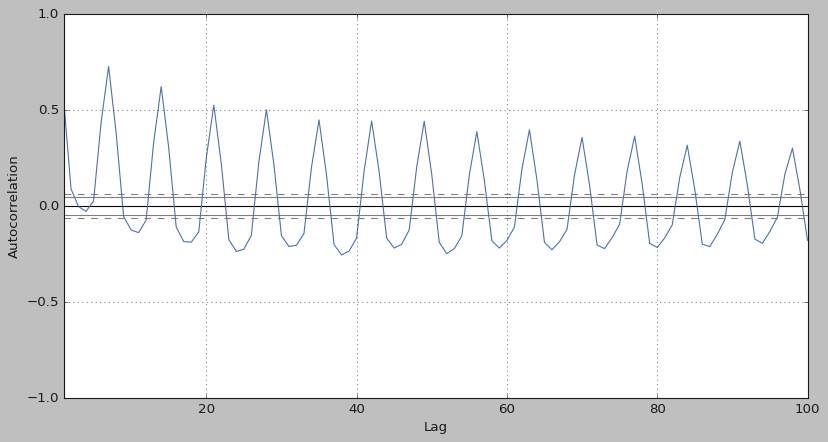

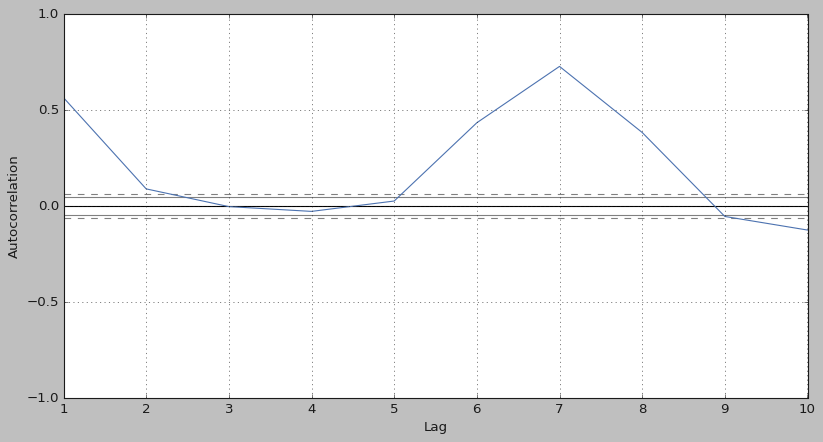

In [38]:
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.xlim(xmax=100);
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.xlim(xmax=10);


Максимальные пики автокоррекции приходятся на ~ 365 дней и колеблются с частотой около 7 дней. Это соответствует нашим интуитивным представлениям о покупках - что это рутинная работа на неделю. Несмотря на то, что эквадорцам, скорее всего, платят ежемесячно, существенной периодичности в этой шкале не видно.

Давайте найдем хорошие значения (p,q).

In [39]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns


# Подбор модели ARIMA
model = auto_arima(
    ts,                   # Временной ряд
    start_p=0,            # Начальный порядок p
    start_q=0,            # Начальный порядок q
    max_p=10,             # Максимальный порядок p
    max_q=10,             # Максимальный порядок q
    seasonal=True,       # Если данные сезонные, поставьте True
    stepwise=True,        # Использовать поэтапный перебор
    trace=True,           # Показать прогресс
    information_criterion='aic',  # Критерий для выбора модели (AIC или BIC)
    max_order=None,       # Общий лимит p+q
    suppress_warnings=True, # Подавлять предупреждения
    error_action='ignore',  # Игнорировать ошибки
    d=None,               # Автоматическое определение разностей d
    max_d=1               # Максимальный порядок разностей d
)

# Результаты
print("Оптимальные параметры ARIMA:", model.order)  # (p, d, q)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26813.816, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=26173.234, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=25946.947, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32547.894, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=25929.892, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=25992.127, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=25911.256, Time=0.57 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=25875.605, Time=0.65 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=25864.186, Time=0.66 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=25897.681, Time=0.45 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=25865.572, Time=1.20 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=25860.277, Time=1.46 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=25735.376, Time=0.94 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=25770.418, Time=0.78 sec
 ARIMA(3,0,4)(0,0,0

/home/artem/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/artem/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/artem/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/artem/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,count,mean,std,min,25%,50%,75%,max
0,1677.0,-0.219952,359.874929,-2757.638218,-183.628401,-22.413153,164.111203,2581.439175


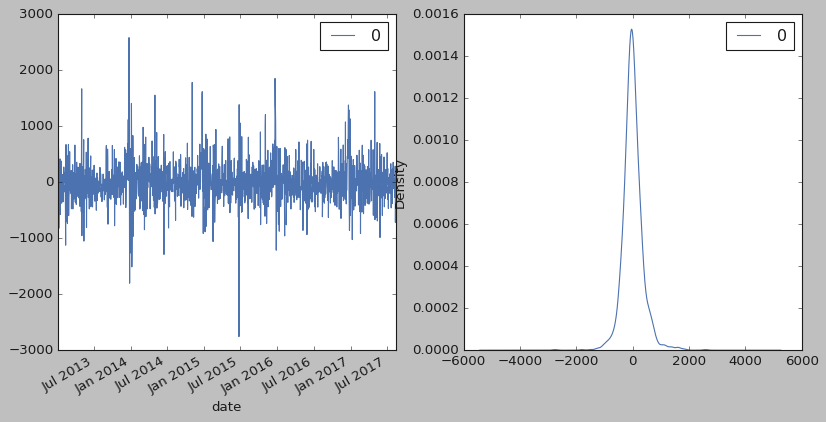

In [40]:
pdq=(5,0,5)
model = ARIMA(ts, order = pdq)
model_fit = model.fit()
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
residuals.plot(ax=axes[0])
residuals.plot(kind='kde',ax=axes[1]);
residuals.describe().T


Мы можем видеть, что получаем гауссово значение с центром в 0 с максимальным отклонением около 400 транзакций.

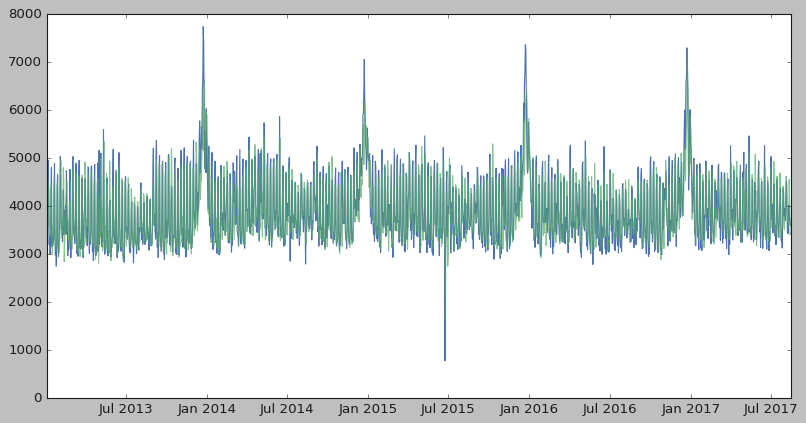

In [41]:
plt.figure(figsize=(12,6))
plt.subplot
plt.plot(ts);
plt.plot(model_fit.fittedvalues,alpha=.7);


Это кажется довольно хорошим результатом. Но кажется у нас наблюдается переобучение. Тем не менее давайте продолжим и разделим данные на обучение и тестирование, чтобы увидеть качество прогнозов, которые они дают.

In [42]:
forecast_len=30
size = int(len(ts)-forecast_len)
train, test = ts[0:size], ts[size:len(ts)]
history = [x for x in train]
predictions = list()

print('Starting the ARIMA predictions...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order = pdq);
    model_fit = model.fit();
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('Predictions finished.\n')
    

predictions_series = pd.Series(predictions, index = test.index)


Starting the ARIMA predictions...




/home/artem/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/artem/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/artem/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/artem/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/artem/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/artem/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to con

Predictions finished.



/home/artem/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



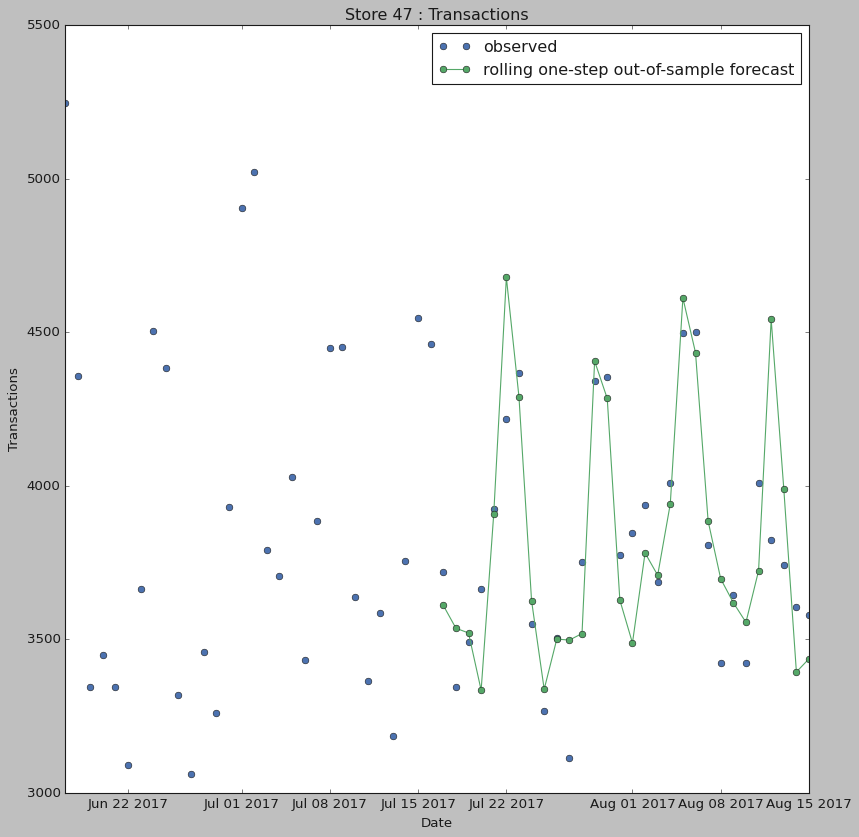

In [43]:
plt.figure(figsize=(12,12))
plt.title('Store 47 : Transactions')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.plot(ts[-2*forecast_len:], 'o', label='observed');
plt.plot(predictions_series, '-o',label='rolling one-step out-of-sample forecast');
plt.legend(loc='upper right');



Результат хороший, предсказания расположенны близко к ответам, это очень напоминает переобочение.

На этом анализ данных заканчиваем, хотя можно анализировать еще. Мы попробовали обучить ARIMA, но получилось не очень. Давайте попробуем что-то другое.

# DATA pipeline

Давайте объединим наши данные и пообучаем простые модели.

Займемся подготовкой

In [44]:
import datetime as dt
from sklearn.base import BaseEstimator, TransformerMixin

class prepare_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("prepare_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        train_stores = X[0].merge(X[1], right_on = 'store_nbr', left_on='store_nbr')
        train_stores_oil = train_stores.merge(X[2], right_on='date', left_on='date')
        train_stores_oil_items = train_stores_oil.merge(X[3], right_on = 'item_nbr', left_on = 'item_nbr')
        train_stores_oil_items_transactions = train_stores_oil_items.merge(X[4], right_on = ['date', 'store_nbr'], left_on = ['date', 'store_nbr'])
        train_stores_oil_items_transactions_hol = train_stores_oil_items_transactions.merge(X[5], right_on = 'date', left_on = 'date')
        
        data_df = train_stores_oil_items_transactions_hol.copy(deep = True)
        
        # change the bool to int
        data_df['onpromotion'] = data_df['onpromotion'].astype(int)
        data_df['transferred'] = data_df['transferred'].astype(int)

        # change the names
        data_df.rename(columns={'type_x': 'st_type', 'type_y': 'hol_type'}, inplace=True)

        # drop the id
        data_df.drop(['id'], axis=1, inplace=True)
        
        print(data_df.head())
        
        # handle date
        data_df['date'] = pd.to_datetime(data_df['date'])
        data_df['date'] = data_df['date'].map(dt.datetime.toordinal)
                
        return data_df


Преобразование для разделения данных

In [45]:
# split dataframe into numerical values, categorical values and date
class split_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("split_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Get columns for each type         
        df_ = X.drop(['date'], axis = 1)
        cols = df_.columns
        num_cols = df_._get_numeric_data().columns
        cat_cols = list(set(cols) - set(num_cols))
        
        data_num_df = X[num_cols]
        data_cat_df = X[cat_cols]
        data_date_df = X['date']
        
        return data_num_df, data_cat_df, data_date_df

Преобразования:
* Заполним недостающие данные в числовых атрибутах 
* Примените стандартный масштаб к числовым атрибутам
* Преобразуйте категориальные данные в числовые


In [46]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

class process_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("process_data -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ### numerical data
        # impute nulls in numerical attributes
        imputer = SimpleImputer(strategy="mean", copy=True)
        num_imp = imputer.fit_transform(X[0])
        data_num_df = pd.DataFrame(num_imp, columns=X[0].columns, index=X[0].index)
        
        # apply standard scaling
        scaler = StandardScaler()
        scaler.fit(data_num_df)
        num_scaled = scaler.transform(data_num_df)
        data_num_df = pd.DataFrame(num_scaled, columns=X[0].columns, index=X[0].index)
        
        ### categorical data
        # one hot encoder
        cat_encoder = OneHotEncoder(sparse_output=False)
        data_cat_1hot = cat_encoder.fit_transform(X[1])
        
        # convert it to datafram with n*99 where n number of rows and 99 is no. of categories
        data_cat_df = pd.DataFrame(data_cat_1hot, columns=cat_encoder.get_feature_names_out()) #, index=X[1].index)
                
        return data_num_df, data_cat_df, X[2]

Еще одно преобразование

In [47]:
class join_df(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("join_df -> init")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ### numerical data
        data_df = X[0].join(X[1])
        data_df = data_df.join(X[2])
        
        return data_df

Используем стабильные данные, а не весь датсет. (данные зависят от цен на нефть)

In [48]:
from sklearn.pipeline import Pipeline

pipe_processing = Pipeline([
        ('prepare_data', prepare_data()),
        ('split_data', split_data()),
        ('process_data', process_data()),
        ('join_data', join_df())
    ])

# our prepared data
data_df = pipe_processing.fit_transform([train_large, stores, oil, items, transactions, holiday_events])


prepare_data -> init
split_data -> init
process_data -> init
join_df -> init
        date  store_nbr  item_nbr  unit_sales  onpromotion   city      state  \
0 2017-05-12          1     96995         1.0            0  Quito  Pichincha   
1 2017-05-12          1     99197         1.0            0  Quito  Pichincha   
2 2017-05-12          1    103520         6.0            0  Quito  Pichincha   
3 2017-05-12          1    103665         4.0            0  Quito  Pichincha   
4 2017-05-12          1    105574        16.0            0  Quito  Pichincha   

  st_type  cluster  dcoilwtico        family  class  perishable  transactions  \
0       D       13       47.83     GROCERY I   1093           0          1982   
1       D       13       47.83     GROCERY I   1067           0          1982   
2       D       13       47.83     GROCERY I   1028           0          1982   
3       D       13       47.83  BREAD/BAKERY   2712           1          1982   
4       D       13       47.83     GR

In [49]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147603 entries, 0 to 1147602
Columns: 110 entries, store_nbr to date
dtypes: float64(109), int64(1)
memory usage: 963.1 MB


In [50]:
# split it according to our feature engineering
X = data_df.drop(['unit_sales'], axis=1)
Y = data_df[['unit_sales']]

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Моделирование и тестирование

Перейдем наконец то к интересной части, пообучаем различные модели на наших объединеных подготовленных данных

Общая функция для моделирования и тестирования

In [52]:
from sklearn.linear_model import LinearRegression,SGDRegressor,ElasticNet,Ridge
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error


def checkModelPerformane(model):
    model.fit(x_train.values, y_train.values)
    
    pred = model.predict(x_test.values)
    
    print("mean_squared_error: ",np.sqrt(mean_squared_error(y_test.values, pred))) 
    print("mean_absolute_error: ", np.sqrt(mean_absolute_error(y_test.values, pred)))


Linear regression

In [53]:
print("LinearRegression")
checkModelPerformane(LinearRegression())


LinearRegression
mean_squared_error:  0.9567074744251727
mean_absolute_error:  0.5621834753627328


Lasso regression

In [54]:
print("lasso regression ")
checkModelPerformane(linear_model.Lasso(alpha=0.1))


lasso regression 
mean_squared_error:  0.9780858216224894
mean_absolute_error:  0.5785074922070075


ElasticNet regression

In [55]:
print("ElasticNet regression ")
checkModelPerformane(ElasticNet())


ElasticNet regression 
mean_squared_error:  0.981102089156904
mean_absolute_error:  0.5823126638554496


Ridge regression

In [56]:
print("Ridge regression ")
checkModelPerformane(Ridge(alpha=1.0))


Ridge regression 
mean_squared_error:  0.956708045987263
mean_absolute_error:  0.5621748752360954


Random forests

In [57]:
# print("Random Forest")
# checkModelPerformane(RandomForestRegressor(random_state=42)) 


Случайный лес требует 20-30 мин на моем железе, поэтому закомментировал.

Что видно? Случайный лес справился с задачей куда лучше, чем другие модели. У остальных результаты очень похожие, и по-хорошему можно поиграться с параметрами для нахождения оптимальных, посмотреть на сколько это может улучшить качество.(по опыту не всегда оправдано) Однако случайный лес работает в разы медленнее. Это все таки его минус.

Однако мы как-то забыли посмотреть результаты на простых данных и сразу кинулись во все тяжкие. Исправляем это недоразумение, может мы уже успели намудрить...)

In [58]:
# split it according to our feature engineering
copy_train = train_large
copy_train.date = copy_train.date.map(dt.datetime.toordinal)
X = copy_train.drop(['unit_sales'], axis=1)
Y = copy_train[['unit_sales']]

In [59]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

Linear regression

In [60]:
print("LinearRegression")
checkModelPerformane(LinearRegression())


LinearRegression
mean_squared_error:  25.41457256408643
mean_absolute_error:  2.7244051143693517


Lasso regression

In [61]:
print("lasso regression ")
checkModelPerformane(linear_model.Lasso(alpha=0.1))


lasso regression 
mean_squared_error:  25.417523996672177
mean_absolute_error:  2.7236633239341077


ElasticNet regression

In [62]:
print("ElasticNet regression ")
checkModelPerformane(ElasticNet())


ElasticNet regression 
mean_squared_error:  25.488784745566605
mean_absolute_error:  2.7333018153368256


Ridge regression

In [63]:
print("Ridge regression ")
checkModelPerformane(Ridge(alpha=1.0))


Ridge regression 
mean_squared_error:  25.41457256759213
mean_absolute_error:  2.7244051027545484


Random forests

In [64]:
# print("Random Forest")
# checkModelPerformane(RandomForestRegressor(random_state=42)) 

Ну что ж, можно смело сказать, что наша подготовка не была зря. Результаты коррелируют с прошлыми, но значительно хуже.

Попробуем найти оптимальные значения для Ridge regression и Random forests. Первая работает напорядок быстрее, вторая куда дольше, но точнее.


Возвращаемся к нашим обработанным данным.

In [65]:
# split it according to our feature engineering
X = data_df.drop(['unit_sales'], axis=1)
Y = data_df[['unit_sales']]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    forest_reg, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,  # Параллельные вычисления
    return_train_score=True)

grid_search.fit(x_train.values, y_train.values)


/home/artem/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/artem/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/artem/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/artem/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

наилучшие параметры для нашей модели

In [71]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Посмотрим, что получиться на тестовых данных для случайного леса.

In [113]:
final_model = grid_search.best_estimator_

# load and process data
test = pd.read_csv("data/test.csv", parse_dates=['date'])

In [114]:
#train_large, stores, oil, items, transactions, holiday_events

train_stores = test.merge(stores, right_on = 'store_nbr', left_on='store_nbr')
train_stores_oil = train_stores.merge(oil, right_on='date', left_on='date')
train_stores_oil_items = train_stores_oil.merge(items, right_on = 'item_nbr', left_on = 'item_nbr')
train_stores_oil_items_transactions = train_stores_oil_items.merge(transactions.groupby(['store_nbr'])['transactions'].mean(), right_on = ['store_nbr'], left_on = ['store_nbr'])


train_stores_oil_items_transactions_hol = train_stores_oil_items_transactions.merge(holiday_events, right_on = 'date', left_on = 'date')

test_df = train_stores_oil_items_transactions_hol.copy(deep = True)

# change the bool to int
test_df['onpromotion'] = test_df['onpromotion'].astype(int)
test_df['transferred'] = test_df['transferred'].astype(int)
# change the names
test_df.rename(columns={'type_x': 'st_type', 'type_y': 'hol_type'}, inplace=True)
# drop the id
test_df.drop(['id'], axis=1, inplace=True)

print(test_df.head())

# handle date
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['date'] = test_df['date'].map(dt.datetime.toordinal)

        date  store_nbr  item_nbr  onpromotion   city      state st_type  \
0 2017-08-24          1     96995            0  Quito  Pichincha       D   
1 2017-08-24          1     99197            0  Quito  Pichincha       D   
2 2017-08-24          1    103501            0  Quito  Pichincha       D   
3 2017-08-24          1    103520            0  Quito  Pichincha       D   
4 2017-08-24          1    103665            0  Quito  Pichincha       D   

   cluster  dcoilwtico        family  class  perishable  transactions  \
0       13       47.24     GROCERY I   1093           0   1523.844272   
1       13       47.24     GROCERY I   1067           0   1523.844272   
2       13       47.24      CLEANING   3008           0   1523.844272   
3       13       47.24     GROCERY I   1028           0   1523.844272   
4       13       47.24  BREAD/BAKERY   2712           1   1523.844272   

  hol_type locale locale_name          description  transferred  
0  Holiday  Local      Ambato  Fundaci

In [115]:
pipe_processing2 = Pipeline([
        ('split_data', split_data()),
        ('process_data', process_data()),
        ('join_data', join_df())
    ])

test_df = pipe_processing2.fit_transform(test_df)

split_data -> init
process_data -> init
join_df -> init


In [116]:
final_predictions = final_model.predict(test_df)

ValueError: X has 90 features, but RandomForestRegressor is expecting 109 features as input.

Ага, и тут вышла неувязочка. Расширить тестовые данные до нужного количества признаков не удалось. Нужно пробовать другое, потому что очевидных действий на ум не пришло.

# Вариант с предсказанием на "авось": медиан, среднее и мод

In [108]:
import pandas as pd

# 1. Читаем test.csv, выбирая только определенные столбцы, и устанавливаем индексы
pd.read_csv("data/test.csv", usecols=[0, 2, 3])\
.set_index(['item_nbr', 'store_nbr'])\
.join(
    # 2. Читаем train.csv, выбирая определенные столбцы, преобразуя 'unit_sales' 
    #    (отрицательные или нулевые значения заменяются на 0).
    pd.read_csv(
        'data/train.csv',
        usecols=[0, 2, 3, 4],
        converters={'unit_sales': lambda u: float(u) if float(u) > 0 else 0},
        skiprows=range(1, 86672217)  # Пропускаем первые 86672217 строк
    )
    # 3. Группируем данные из train.csv по 'item_nbr' и 'store_nbr' 
    #    и считаем медиану для 'unit_sales'
    .groupby(['item_nbr', 'store_nbr'])['unit_sales'].median()
    .to_frame('unit_sales'),  # Преобразуем в DataFrame с именем столбца 'unit_sales'
    
    how='left'  # Джойним test.csv с train.csv по 'item_nbr' и 'store_nbr'
    # 4. Заполняем пропущенные значения в 'unit_sales' нулями
    # 5. Сохраняем результат в файл median.csv с двумя знаками после запятой

).fillna(0).to_csv('median.csv', float_format='%.2f', index=None)


In [109]:
import pandas as pd

# 1. Читаем test.csv, выбирая только определенные столбцы, и устанавливаем индексы
pd.read_csv("data/test.csv", usecols=[0, 2, 3])\
.set_index(['item_nbr', 'store_nbr'])\
.join(
    # 2. Читаем train.csv, выбирая определенные столбцы, преобразуя 'unit_sales' 
    #    (отрицательные или нулевые значения заменяются на 0).
    pd.read_csv(
        'data/train.csv',
        usecols=[0, 2, 3, 4],
        converters={'unit_sales': lambda u: float(u) if float(u) > 0 else 0},
        skiprows=range(1, 86672217)  # Пропускаем первые 86672217 строк
    )
    # 3. Группируем данные из train.csv по 'item_nbr' и 'store_nbr' 
    #    и считаем медиану для 'unit_sales'
    .groupby(['item_nbr', 'store_nbr'])['unit_sales'].mean()
    .to_frame('unit_sales'),  # Преобразуем в DataFrame с именем столбца 'unit_sales'
    
    how='left'  # Джойним test.csv с train.csv по 'item_nbr' и 'store_nbr'
    # 4. Заполняем пропущенные значения в 'unit_sales' нулями
    # 5. Сохраняем результат в файл median.csv с двумя знаками после запятой

).fillna(0).to_csv('mean.csv', float_format='%.2f', index=None)


In [111]:
import pandas as pd

# 1. Читаем test.csv, выбирая только определенные столбцы, и устанавливаем индексы
test = pd.read_csv("data/test.csv", usecols=[0, 2, 3]).set_index(['item_nbr', 'store_nbr'])

# 2. Читаем train.csv, выбирая определенные столбцы, преобразуя 'unit_sales'
train = pd.read_csv(
    'data/train.csv',
    usecols=[0, 2, 3, 4],
    converters={'unit_sales': lambda u: float(u) if float(u) > 0 else 0},
    skiprows=range(1, 86672217)  # Пропускаем первые 86672217 строк
)

# 3. Группируем данные из train.csv по 'item_nbr' и 'store_nbr'
#    и вычисляем моду для 'unit_sales'
mode_unit_sales = train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].apply(
    lambda x: x.mode().iloc[0] if not x.mode().empty else 0  # Берем первую моду или заполняем 0
).to_frame('unit_sales')

# 4. Джойним test.csv с вычисленной модой по 'item_nbr' и 'store_nbr'
df = test.join(mode_unit_sales, how='left').fillna(0)

# 5. Вывод первых двух строк результата
print(df.head(2))


                           id  unit_sales
item_nbr store_nbr                       
96995    1          125497040         1.0
99197    1          125497041         1.0


In [112]:
df[['id','unit_sales']].to_csv('mode.csv.gz', index=False, float_format='%.3f', compression='gzip')


К сожалению, не смог загрузить результаты в Kaggle, но вероятно их результаты были бы в диапозоне 0.65-0.70 по открытой метрике NWRMSLE, если смотреть похожие работы. В данный момент, лучший результат в приватной части этого соревнования 0.50918. 
https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/leaderboard?

В целом, это неплохой средний результат, главное его очень быстро получить.

# KNeighborsRegressor


Давайте попробуем обучить такую модель, раз уж прошлый вариант на всех данных не прошел.

выберем немного другие данные из стабильного периода

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from datetime import date, timedelta

df_train = pd.read_csv(
    'data/train.csv', usecols=[1, 2, 3, 4],
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 117477878)  # 2017-06-01
)

df_train = df_train.set_index(
    ["store_nbr", "item_nbr", "date"]).unstack(
        level=-1).fillna(0)
df_train.columns = df_train.columns.get_level_values(1)

# В результате получается таблица, где:
# Индексы: пары store_nbr и item_nbr.
# Столбцы: уникальные даты.
# Значения: значения onpromotion для каждой даты

df_train.head(1)


,date,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
store_nbr,item_nbr,,,,,,,,,,,,,,,,,,,,,
1,96995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,...,1.098612,1.098612,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0


In [7]:
model = KNeighborsRegressor(
    n_neighbors=100, n_jobs=-1,
    leaf_size=100,  # weights='distance'
)


In [8]:
X_train = np.concatenate([
    df_train[
        pd.date_range(date(2017, 6, 7) + timedelta(days=i * 7), periods=14)
    ].values for i in range(6)
], axis=0)
y_train = np.concatenate([
    df_train[
        pd.date_range(date(2017, 6, 21) + timedelta(days=i * 7), periods=16)
    ].values for i in range(6)
], axis=0)
X_test = df_train[pd.date_range("2017-08-01", periods=14)].values

Итог: X_train содержит данные для 14-дневных периодов, взятых с интервалом в 1 неделю, для 6 последовательных интервалов. Все эти массивы объединяются в один большой массив. 
Аналогично для других

In [9]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
df_preds = pd.DataFrame(
    y_pred, index=df_train.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


Получили предсказание, затем возвращаем его к исходному виду.

In [10]:
df_test = pd.read_csv(
    "data/test.csv", usecols=[0, 1, 2, 3],
    parse_dates=["date"] 
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

submission = df_test.join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.expm1(submission["unit_sales"])
submission[['id','unit_sales']].to_csv('knn.csv.gz', index=False, float_format='%.3f', compression='gzip')

С загрузкой материалов на Kaggle снова проблемы, посмотрим на нашу метрику

In [13]:
from sklearn.model_selection import train_test_split

# split it according to our feature engineering
X = X_train
Y = y_train

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [16]:
model.fit(x_train, y_train)
pred = model.predict(x_test)



In [25]:
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, pred)))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, pred))


Root Mean Squared Error (RMSE): 0.6656002608704837
Mean Absolute Error (MAE): 0.5055543431779638


Ну выглядит достаточно хорошо, даже лучше, чем случайный лес. Хорошо конечно было бы узнать результат от сайта.

Подводя некоторый итог, из полученных результатов лучше всего себя показала модель KNeighborsRegressor. Если же нас интересует большая скорость вычислений, то можно воспользоваться тем же банальным средним или логической регрессией.

Возможно проведя более чательный анализ, можно получить интересные результаты с помощью сезонных моделей, в конце концов такие зависимости точно присутствуют, но я на них сильно не зацикливался, кажется решение можно найти проще. Это я хочу попробовать в отдельном файле var_2, тк в этом файле уже много всего.